# Exploring QAOA Against Classical Methods to Solve the MaxCut Problem

Recently, I learned about Quantum Machine Learning (QML), and specifically, the Quantum Approximate Optimization Algorithm (QAOA) through [IBM Qiskit's excellent videos](https://www.youtube.com/watch?v=YpLzSQPrgSc&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=11&pp=iAQB).

As you'd guess if you're acquainted with my GitHub, I will now attempt to use what I learned to solve the MaxCut problem for myself using QAOA, and compare it against the classical brute force approach.

## A Brief About the Problem

The MaxCut problem is classified as NP-hard, and involves partitioning the vertices of a graph into two disjoint sets in such a way that the number of edges crossing between the sets is maximized.

## Methodology

I will begin by constructing and visualizing the graph, then build and evaluate our models - the brute force algorithm and QAOA.

I will conclude with a discussion of this notebook and its results.

Let's get started!



## Initialize and Visualize the Graph

[[0 1 0 1 1]
 [1 0 1 1 1]
 [0 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]]


{(0, 1): Text(0.7398307386598333, 0.8567756179775676, '1'),
 (0, 3): Text(0.48340659682008325, 0.7081136663529437, '1'),
 (0, 4): Text(0.6230414156673907, 0.545779021170022, '1'),
 (1, 2): Text(0.46371310414958544, 0.7537979568560993, '1'),
 (1, 3): Text(0.6351052441271207, 0.6671738698065159, '1'),
 (1, 4): Text(0.7747410816769129, 0.5048437769608847, '1')}

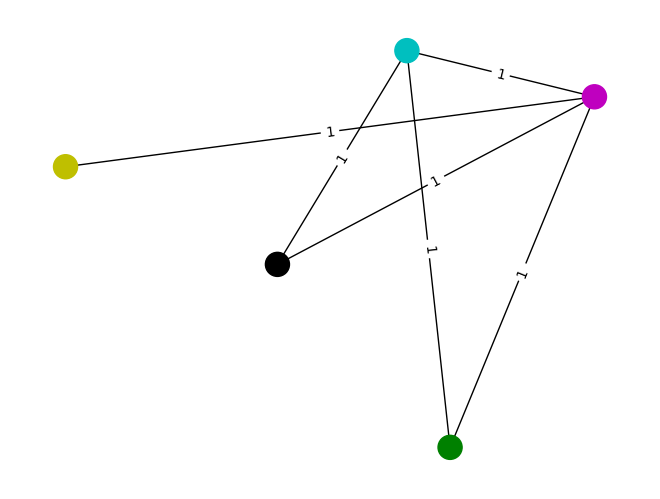

In [26]:
import numpy as np
import networkx as nx

nodes = 5

seed = 20 # for reproducibility
p = 0.85

rng = np.random.default_rng(seed)
adj = rng.choice([0, 1], size=(5,5),p=[1-p, p]) # adjacency matrix
adj = np.triu(adj, 1)
adj = adj + adj.T

print(adj)

G = nx.from_numpy_array(adj)

layout = nx.random_layout(G, seed=seed)
colors = ["c", "m", "y", "k", "g"]
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

## Define the Brute Force Algorithm

Here, one exhaustively calculates the value of the cut by trying all binary assignments.

A vertex is either 0 or 1 in such an assignment, meaning that the vertex is either in set 1 or 2, respectively.

The algorithm returns the binary assignment that corresponds to the maximum number of crossing edges.

We begin by defining two important functions -
* `bitstring_value` calculates the value of a cut given a bitstring and an adjacency matrix.
* `bit_rep` returns the binary representation of a given integer with an L length list of binary values.

In [27]:
def bitstring_value(b, w):
  """
  Returns the value of a cut.
  Args:
    b: binary string as np array
    w: adjacency matrix
  """
  cross_edges = np.outer(b, (1-b)) # only consider edges between different partitions
  #print(binary_adj)
  binary_adj = np.where(w != 0, 1, 0) # edges present are 1
  #print(binary_adj)
  return np.sum(binary_adj * cross_edges) # count cut edges

def bit_rep(n, L):
  """
  Returns the binary representation of length L for an int n.
  Args:
    n: integer in decimal
    L: length of the resultant binary representation
  """
  return [int(x) for x in np.binary_repr(n, L)]

Next, we run the brute force algorithm.

In [28]:
import time

L = nodes

def brute_force(L):
  maximum = 2**L # max number of cuts
  soln = 0
  bitstring = []

  for i in range(maximum):
    current = bit_rep(i, L)
    value = bitstring_value(np.array(current), adj)

    if value > soln:
      soln = value
      bitstring = current

  print(f"MaxCut Value: {soln}, for Bitstring: {bitstring}.")
  return bitstring, value

bitstring, value = brute_force(L)




MaxCut Value: 5, for Bitstring: [0, 0, 1, 1, 1].


## Preparing the Hamiltonian

To use QAOA, we first need to convert our MaxCut problem into an Ising Hamiltonian. Let's do it as follows:

We first start with the problem formulation.

We understand the MaxCut problem to be a quadratic problem for which we're trying to find the optimal bitstring `x` that maximizes our cost function. Our cost function looks as follows:

$$C(x) = \sum^n_{i,j=1}W_{ij}x_i(1-x_j)$$

Next, we need to formulate our problem as a [Quadratic Unconstrained Binary Optimization (QUBO) problem](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization), which we can then easily translate to an Ising Hamiltonian. I won't be explaining QUBO in this notebook for the sake of brevity, but the structure of a QUBO problem is as follows:

$$C(x)=x^TQx+c^Tx$$

where Q is our matrix and c is a constant vector. So our original cost function in the QUBO formalism is:

$$C(x) = \sum^n_{i,j=1}x_iQ_{ij}x_j+\sum^n_{i=1}c_ix_i$$

### How to Find the Hamiltonian?

We want our cost Hamiltonian ($H_c$) to be diagonal in the computational basis, so we must select operators that satisfy this constraint. The only Pauli operator we can select is therefore $Z_i$.

If we apply $ Z_i |x\rangle = (-1)^{x_i} |x\rangle = (1 - 2x_i)|x\rangle $

So,
$$
\frac{I - Z_i}{2} |x\rangle = x_i |x\rangle
$$

So plug in the form for \( x_i \) above into the cost function:

$$
H_c = \sum_{i \neq j}^{n} Q_{ij} \frac{1 - Z_i}{2} \frac{1 - Z_j}{2} + \sum_{i=1}^{n} c_i \frac{1 - Z_i}{2}
$$

Expand and collect. We get this form:
$$
H_C = \sum_{i,j=1}^{n} \frac{1}{4} Q_{ij} Z_i Z_j
- \sum_{i=1}^n \frac{1}{2} \left( c_i + \sum_{j=1}^{n} Q_{ij} \right) Z_i
+ \left( \sum_{i,j=1}^{n} \frac{Q_{ij}}{4} + \sum_{i=1}^{n} \frac{c_i}{2} \right)
$$

### The Ising Hamiltonian We Code

The coded Hamiltonian sums each unique edge once with a coefficient of $\frac{1}{2}$ per $Z_i Z_j$ term, which matches the analytical Hamiltonian's double sum with a $\frac{1}{4}$ coefficient when single-qubit terms ($c_i = 0$) are omitted—since the analytical form double-counts each undirected edge. Setting $c_i = 0$ reflects the pure MaxCut problem without further constraints (like balanced sets), where only pairwise interactions (edges) matter and no single-qubit penalties are included.

In [29]:
from qiskit.quantum_info import Pauli, SparsePauliOp

def operator(adj):
  """
  Returns:
    SparsePauliOp: operator for the MaxCut Hamiltonian.
    float: Constant shift for energy scores

  Args:
    adj: the adjacency matrix for the system
  """

  nodes = len(adj)
  pauli_list = []
  coeffs = []
  shift = 0

  # Loop over all distinct edges (i < j, symmetric matrix)
  for i in range(nodes):
    for j in range(i):
      if adj[i][j] != 0:
        x_p = np.zeros(nodes, dtype=bool) # since there are no X's in our H_c.
        z_p = np.zeros(nodes, dtype=bool)
        z_p[i] = True
        z_p[j] = True
        pauli_list.append(Pauli((z_p, x_p)))
        coeffs.append(adj[i][j]/2) # no need to divide by 4: we're not double-counting
        shift += adj[i][j]/2

  return SparsePauliOp(pauli_list, coeffs=coeffs), shift

qubit_op, offset = operator(adj)


## Performing QAOA

Next, we run QAOA to find an approximate solution to the MaxCut problem using statevector simulation.

We then extract and print the most likely bitstring solution along with its corresponding MaxCut objective value.

For the optimization, we use the COBYLA optimizer, which is a popular classical algorithm used in quantum variational workflows, especially when gradients are difficult to compute or unavailable. It works by iteratively approximating the optimization landscape with linear models and moving towards a solution that satisfies any imposed constraints.

In [30]:
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Pauli
from qiskit.result import QuasiDistribution
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

sampler = StatevectorSampler(seed=seed)


def sample_most_likely(state_vector):
    """
    Maps bitstring to probabilities.
    Args:
        state vector: a quasi distribution.

    Returns:
        Array of bits.
    """
    return np.array([int(bit) for bit in max(state_vector.items(), key=lambda x: x[1])[0][::-1]])


algorithm_globals.random_seed = seed
optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=3)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Value computed by QAOA: {bitstring_value(x, adj)}")

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


[1 1 0 0 0]
Value computed by QAOA: 5


We see that both the brute force and QAOA approaches produce the same answer for the optimal cut value of 5.

## Conclusion

This notebook showed how QAOA can solve the MaxCut problem and match classical brute-force results even on small test graphs. By laying out both the classical and quantum approaches step-by-step, we could directly compare their outputs and see that quantum algorithms are useful for these combinatorial tasks. The workflow, from problem setup to Hamiltonian formulation and algorithm implementation, was straightforward, and everything worked as expected.

For future notebooks, I’d like to push this further: test larger graphs, introduce noise and hardware runs, or investigate other NP-hard optimization problems using quantum techniques!